In [1]:
# Main imports
import curiosidade
import torch.nn
import torch


# Example-related imports
import collections
import functools

import torchmetrics
import tqdm.auto
import matplotlib.pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2

/media/nvme/prober/venvs/py3.9.10/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Base model setup up

in this example, we will take a look on how to handle probing modules that have multiple outputs. More precisely, we'll probe the following module:

In [2]:
class BifurcationModule(torch.nn.Module):
    def __init__(self, input_dim: int, output_dim_a: int, output_dim_b: int):
        super().__init__()
        
        self.params_in = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 25),
            torch.nn.ReLU(inplace=True),
        )
        
        self.params_a = torch.nn.Sequential(
            torch.nn.Linear(25, 35),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(35, output_dim_a),
        )
        
        self.params_b = torch.nn.Sequential(
            torch.nn.Linear(25, 15),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(15, output_dim_b),
        )
    
    def forward(self, X):
        out = X
        out = self.params_in(out)
        out_a = self.params_a(out)
        out_b = self.params_b(out)
        return out_a, out_b

### Set up dataloaders

In [3]:
torch.random.manual_seed(32)

dataset_length, dataset_dimension = (400, 5)

X = torch.randn(dataset_length, dataset_dimension).float()
y = X.sum(axis=1).round().abs().long()

class_count = y.unique().numel()

print(f"{class_count = }")

class_count = 8


In [4]:
train_size = int(0.9 * dataset_length)
eval_size = int(0.05 * dataset_length)
test_size = dataset_length - train_size - eval_size

df = torch.utils.data.TensorDataset(X, y)
df_train, df_eval, df_test = torch.utils.data.random_split(
    df, lengths=[train_size, eval_size, test_size],
)

probing_dataloader_train = torch.utils.data.DataLoader(
    df_train,
    batch_size=8,
    shuffle=True,
)

probing_dataloader_eval = torch.utils.data.DataLoader(
    df_eval,
    batch_size=16,
    shuffle=False,
)

probing_dataloader_test = torch.utils.data.DataLoader(
    df_test,
    batch_size=16,
    shuffle=False,
)

### Set up probed model with bifurcation module

In [5]:
class BaseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        out_dim_a = 17
        out_dim_b = 13
        
        self.params = torch.nn.Sequential(
            collections.OrderedDict((
                ("lin1", torch.nn.Linear(dataset_dimension, 15, bias=True)),
                ("relu1", torch.nn.ReLU(inplace=True)),
                ("lin2", torch.nn.Linear(15, 25, bias=True)),
                ("relu2", torch.nn.ReLU(inplace=True)),
                ("bifurcation", BifurcationModule(25, out_dim_a, out_dim_b)),
            )),
        )
        
        self.params_output = torch.nn.Linear(out_dim_a + out_dim_b, class_count)
    
    def forward(self, X):
        out = X
        out_a, out_b = self.params(out)
        out = torch.cat((out_a, out_b), dim=-1)
        out = self.params_output(out)
        return out
    
    
probed_pretrained_model = BaseModel()
probed_optim = torch.optim.Adam(probed_pretrained_model.parameters(), lr=0.01)
probed_loss_fn = torch.nn.CrossEntropyLoss()
probed_num_train_epochs = 25

mov_avg_weight = 0.9
mov_avg_loss = 0.0

pbar = tqdm.auto.tqdm(range(1, 1 + probed_num_train_epochs))

for epoch in pbar:
    for X_batch, y_batch in probing_dataloader_train:
        probed_optim.zero_grad()
        y_logits = probed_pretrained_model(X_batch)
        loss = probed_loss_fn(input=y_logits, target=y_batch)
        loss.backward()
        probed_optim.step()
        
        mov_avg_loss = (
            mov_avg_weight * mov_avg_loss +
            (1.0 - mov_avg_weight) * float(loss.cpu().detach().item())
        )
    
    
    pbar.set_description(f"{epoch=} of {probed_num_train_epochs} - {mov_avg_loss=:.3f}")

epoch=25 of 25 - mov_avg_loss=0.292: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 15.32it/s]


## Probing task setup

A probing model can receive multiple inputs, which happens to be de case if the probed module has multiple outputs.

How exactly these inputs are be combined to form a single output is up to you. In this example, we will simply concatenate the inputs, and mix them with a linear layer.

In [6]:
class ProbingModelForBifurcation(torch.nn.Module):
    def __init__(self, input_dim_a: int, input_dim_b: int, output_dim):
        super().__init__()
        
        self.params = torch.nn.Sequential(
            collections.OrderedDict((
                ("probing_lin1", torch.nn.Linear(input_dim_a + input_dim_b, 15)),
                ("probing_relu1", torch.nn.ReLU(inplace=True)),
                ("probing_lin2", torch.nn.Linear(15, output_dim)),
            ))
        )
        
    def forward(self, X_a: torch.Tensor, X_b: torch.Tensor):
        out = torch.cat((X_a, X_b), dim=-1)
        out = self.params(out)
        return out

    
probing_model_fn = ProbingModelForBifurcation

In [7]:
acc_fn = torchmetrics.Accuracy(num_classes=class_count)
f1_fn = torchmetrics.F1Score(num_classes=class_count)


def metrics_fn(logits: torch.Tensor, truth_labels: torch.Tensor) -> dict[str, float]:
    accuracy = acc_fn(logits, truth_labels).detach().cpu().item()
    f1 = f1_fn(logits, truth_labels).detach().cpu().item()
    return {"accuracy": accuracy, "f1": f1}


task = curiosidade.ProbingTaskCustom(
    probing_dataloader_train=probing_dataloader_train,
    probing_dataloader_eval=probing_dataloader_eval,
    probing_dataloader_test=probing_dataloader_test,
    loss_fn=torch.nn.CrossEntropyLoss(),
    task_name="task with bifurcation (example #5)",
    task_type="classification",
    output_dim=class_count,
    metrics_fn=metrics_fn,
)

probing_factory = curiosidade.ProbingModelFactory(
    probing_model_fn=probing_model_fn,
    optim_fn=functools.partial(torch.optim.Adam, lr=0.005),
    task=task,
)

prober_container = curiosidade.attach_probers(
    base_model=probed_pretrained_model,
    probing_model_factory=probing_factory,
    modules_to_attach="params.bifurcation",
    random_seed=16,
    prune_unrelated_modules="infer",
)

prober_container

ProbingModelContainer:
(a): Base model: InferencePrunerExtensor(TorchModuleAdapter(BaseModel(
 |  |  (params): Sequential(
 |  |    (lin1): Linear(in_features=5, out_features=15, bias=True)
 |  |    (relu1): ReLU(inplace=True)
 |  |    (lin2): Linear(in_features=15, out_features=25, bias=True)
 |  |    (relu2): ReLU(inplace=True)
 |  |    (bifurcation): BifurcationModule(
 |  |      (params_in): Sequential(
 |  |        (0): Linear(in_features=25, out_features=25, bias=True)
 |  |        (1): ReLU(inplace=True)
 |  |      )
 |  |      (params_a): Sequential(
 |  |        (0): Linear(in_features=25, out_features=35, bias=True)
 |  |        (1): ReLU(inplace=True)
 |  |        (2): Linear(in_features=35, out_features=17, bias=True)
 |  |      )
 |  |      (params_b): Sequential(
 |  |        (0): Linear(in_features=25, out_features=15, bias=True)
 |  |        (1): ReLU(inplace=True)
 |  |        (2): Linear(in_features=15, out_features=13, bias=True)
 |  |      )
 |  |    )
 |  |  )
 |  

In [8]:
probing_results = prober_container.train(num_epochs=10, show_progress_bar=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.83it/s]


## Analyzing probing results

In [9]:
probing_results

ProbingResults(
    train = MetricPack with 1350 values stored in:
    (0, 'loss', 'params.bifurcation', 1): 2.3428378105163574
    (0, 'accuracy', 'params.bifurcation', 1): 0.0
    (0, 'f1', 'params.bifurcation', 1): 0.0
    ...
    (9, 'loss', 'params.bifurcation', 45): 0.22841955721378326
    (9, 'accuracy', 'params.bifurcation', 45): 0.875
    (9, 'f1', 'params.bifurcation', 45): 0.875,
    eval  = MetricPack with 60 values stored in:
    (0, 'loss', 'params.bifurcation', 1): 0.7162778973579407
    (0, 'accuracy', 'params.bifurcation', 1): 0.75
    (0, 'f1', 'params.bifurcation', 1): 0.75
    ...
    (9, 'loss', 'params.bifurcation', 2): 0.16195259988307953
    (9, 'accuracy', 'params.bifurcation', 2): 1.0
    (9, 'f1', 'params.bifurcation', 2): 1.0,
    test  = MetricPack with 6 values stored in:
    (-1, 'loss', 'params.bifurcation', 1): 0.2170076072216034
    (-1, 'accuracy', 'params.bifurcation', 1): 0.875
    (-1, 'f1', 'params.bifurcation', 1): 0.875
    (-1, 'loss', 'params.

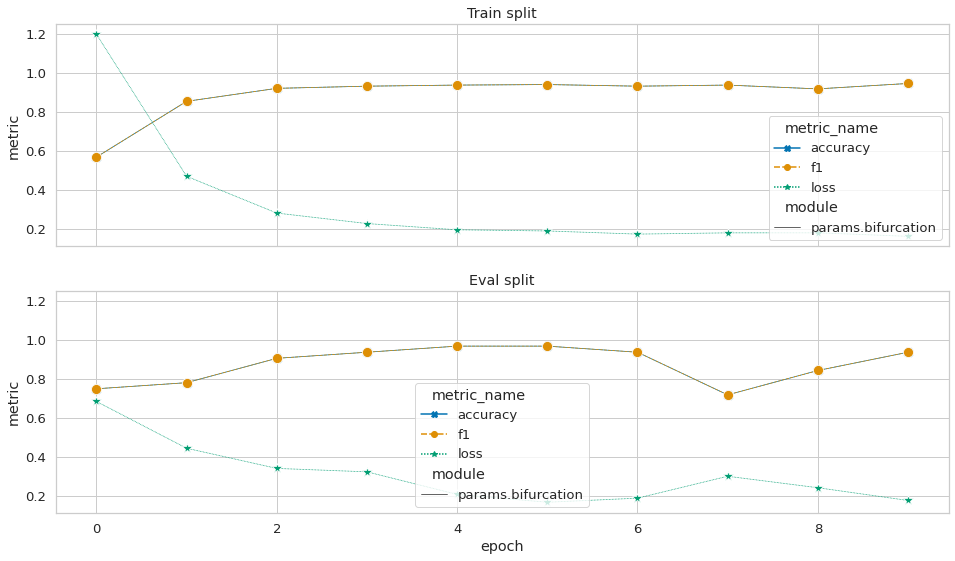

In [10]:
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1.2,
    palette="colorblind",
)

fig, (ax_train, ax_eval) = plt.subplots(2, figsize=(16, 9), sharex=True, sharey=True)

df_train, df_eval, df_test = probing_results.to_pandas(aggregate_by=["batch_index"])

common_kwargs = dict(
    hue="metric_name",
    y="metric",
    x="epoch",
    size="module",
    style="metric_name",
    markers=["X", "o", "*"],
    markersize=10,
    size_order=["params.bifurcation"],
)

sns.lineplot(data=df_train, ax=ax_train, **common_kwargs)
sns.lineplot(data=df_eval, ax=ax_eval, **common_kwargs)

ax_train.set_title("Train split")
ax_eval.set_title("Eval split")

plt.show();

In [11]:
df_test

,epoch,metric_name,module,metric
0,-1,accuracy,params.bifurcation,0.937500
1,-1,f1,params.bifurcation,0.937500
2,-1,loss,params.bifurcation,0.110226


## Probing modules with distinct output count

What happens if we want to probe modules with a different output count (e.g. a multi-output module and a single output module)? In that case, we need to take every scenario into consideration in the probing module architecture, both in the probing module instantiation, and the probing module forward method.

In [12]:
class ProbingModelForBifurcation(torch.nn.Module):
    def __init__(self, input_dim_a: int, input_dim_b: int, output_dim: int = None):
        super().__init__()
        
        if output_dim is not None:
            # Probed module with 2 output tensors
            total_input_dim = input_dim_a + input_dim_b
            
        else:
            # Probed module with a single output tensor
            total_input_dim = input_dim_a
            output_dim = input_dim_b
        
        self.params = torch.nn.Sequential(
            collections.OrderedDict((
                ("probing_lin1", torch.nn.Linear(total_input_dim, 15)),
                ("probing_relu1", torch.nn.ReLU(inplace=True)),
                ("probing_lin2", torch.nn.Linear(15, output_dim)),
            ))
        )
        
    def forward(self, X_a, X_b=None):
        if X_b is not None:
            # Probed module with 2 output tensors
            out = torch.cat((X_a, X_b), dim=-1)
        
        else:
            # Probed module with 1 output tensor
            out = X_a
            
        out = self.params(out)
        
        return out

    
probing_model_fn = ProbingModelForBifurcation

In [13]:
probing_factory = curiosidade.ProbingModelFactory(
    probing_model_fn=probing_model_fn,
    optim_fn=functools.partial(torch.optim.Adam, lr=0.005),
    task=task,
)

prober_container = curiosidade.attach_probers(
    base_model=probed_pretrained_model,
    probing_model_factory=probing_factory,
    modules_to_attach=["params.bifurcation", "params.relu1"],
    random_seed=16,
    prune_unrelated_modules="infer",
)

prober_container

ProbingModelContainer:
(a): Base model: InferencePrunerExtensor(TorchModuleAdapter(BaseModel(
 |  |  (params): Sequential(
 |  |    (lin1): Linear(in_features=5, out_features=15, bias=True)
 |  |    (relu1): ReLU(inplace=True)
 |  |    (lin2): Linear(in_features=15, out_features=25, bias=True)
 |  |    (relu2): ReLU(inplace=True)
 |  |    (bifurcation): BifurcationModule(
 |  |      (params_in): Sequential(
 |  |        (0): Linear(in_features=25, out_features=25, bias=True)
 |  |        (1): ReLU(inplace=True)
 |  |      )
 |  |      (params_a): Sequential(
 |  |        (0): Linear(in_features=25, out_features=35, bias=True)
 |  |        (1): ReLU(inplace=True)
 |  |        (2): Linear(in_features=35, out_features=17, bias=True)
 |  |      )
 |  |      (params_b): Sequential(
 |  |        (0): Linear(in_features=25, out_features=15, bias=True)
 |  |        (1): ReLU(inplace=True)
 |  |        (2): Linear(in_features=15, out_features=13, bias=True)
 |  |      )
 |  |    )
 |  |  )
 |  

In [14]:
probing_results = prober_container.train(num_epochs=10, show_progress_bar=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.84it/s]


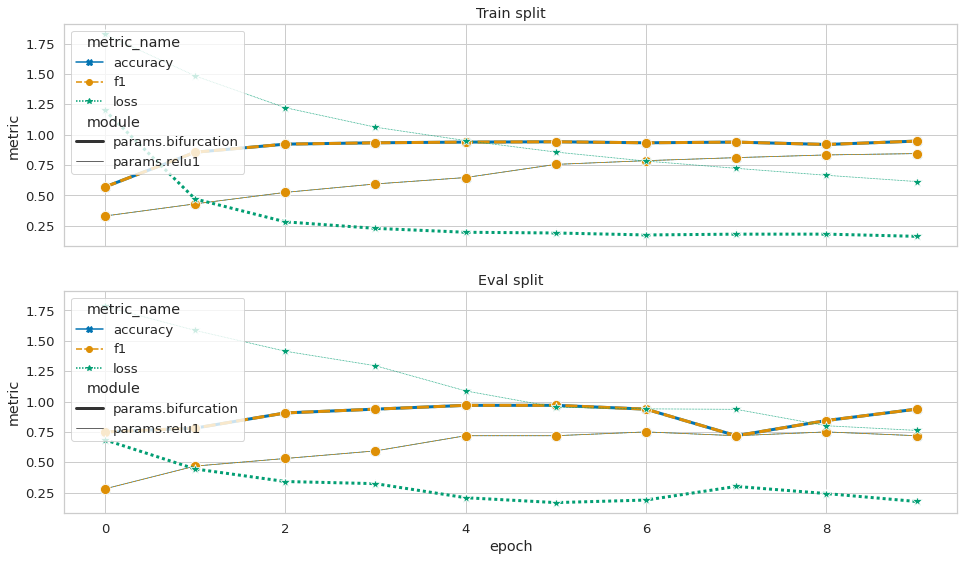

In [15]:
sns.set_theme(
    context="notebook",
    style="whitegrid",
    font_scale=1.2,
    palette="colorblind",
)

fig, (ax_train, ax_eval) = plt.subplots(2, figsize=(16, 9), sharex=True, sharey=True)

df_train, df_eval, df_test = probing_results.to_pandas(aggregate_by=["batch_index"])

common_kwargs = dict(
    hue="metric_name",
    y="metric",
    x="epoch",
    size="module",
    style="metric_name",
    markers=["X", "o", "*"],
    markersize=10,
    size_order=["params.bifurcation", "params.relu1"],
)

sns.lineplot(data=df_train, ax=ax_train, **common_kwargs)
sns.lineplot(data=df_eval, ax=ax_eval, **common_kwargs)

ax_train.set_title("Train split")
ax_eval.set_title("Eval split")

plt.show();